# Sepsis Transformer – Shape & Dataflow Debugger

This notebook will help you verify that every tensor flowing through your
dataset, collate, and transformer has the shapes you expect, and will
produce both a textual summary and a visual computation graph.

---

## 1. Imports

```python
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# For summarizing
try:
    from torchinfo import summary
except ImportError:
    !pip install torchinfo -q
    from torchinfo import summary

# For graph viz
try:
    from torchviz import make_dot
except ImportError:
    !pip install torchviz -q
    from torchviz import make_dot

# For progress bars (optional)
from tqdm import tqdm

In [1]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# For summarizing
try:
    from torchinfo import summary
except ImportError:
    !pip install torchinfo -q
    from torchinfo import summary

# For graph viz
try:
    from torchviz import make_dot
except ImportError:
    !pip install torchviz -q
    from torchviz import make_dot

# For progress bars (optional)
from tqdm import tqdm

In [3]:
from custom_dataset import *
from architectures import *
from grid_search import get_data, setup_base_config, setup_device, get_loss_fn, run_grid_search, pipeline, save_best_models, DataWrapper, get_data

In [4]:
config = setup_base_config()
config["dataset_type"] = "undersampled"
data = get_data(config, "train")

In [5]:
train_loader = data.loader
first_batch = next(iter(train_loader))

In [6]:
device = setup_device()

Using MPS device


In [7]:
X, y, mask = first_batch
X, y, mask = X.to(device), y.to(device), mask.to(device)
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("mask shape: ", mask.shape)


X shape:  torch.Size([305, 256, 107])
y shape:  torch.Size([256])
mask shape:  torch.Size([305, 256])


In [8]:
T, B, F = X.shape
print("T: ", T)
print("B: ", B)
print("F: ", F)
print("shape of X: ", X.shape)

T:  305
B:  256
F:  107
shape of X:  torch.Size([305, 256, 107])


In [9]:

model = TransformerTimeSeries(input_dim=F).to(device)
y = model(X, mask)

print(f">>> Output shape: {y.shape}    (expect B={B})")

/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


>>> Output shape: torch.Size([256])    (expect B=256)


In [10]:
summary(
    model,
    input_data=(X, mask),
    dtypes=[torch.float32, torch.bool],
    depth=3
)

Layer (type:depth-idx)                        Output Shape              Param #
TransformerTimeSeries                         [256]                     281,152
├─Linear: 1-1                                 [305, 256, 64]            6,912
├─PositionalEncoding: 1-2                     [305, 256, 64]            --
│    └─Dropout: 2-1                           [305, 256, 64]            --
├─TransformerEncoder: 1-3                     [305, 256, 64]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [305, 256, 64]            281,152
│    │    └─TransformerEncoderLayer: 3-2      [305, 256, 64]            281,152
├─Linear: 1-4                                 [256, 1]                  65
Total params: 850,433
Trainable params: 850,433
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 163.48
Input size (MB): 33.73
Forward/backward pass size (MB): 2838.37
Params size (MB): 2.14
Estimated Total Size (MB):

In [11]:
from torchviz import make_dot
import graphviz

In [12]:
from graphviz import Source

In [13]:
import os
print(os.environ.get("PATH", "").split(os.pathsep))

['/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/bin', '/usr/bin', '/bin', '/usr/sbin', '/sbin', '/usr/local/bin', '/opt/homebrew/bin']


In [14]:
!dot -V

dot - graphviz version 12.2.1 (20241206.2353)


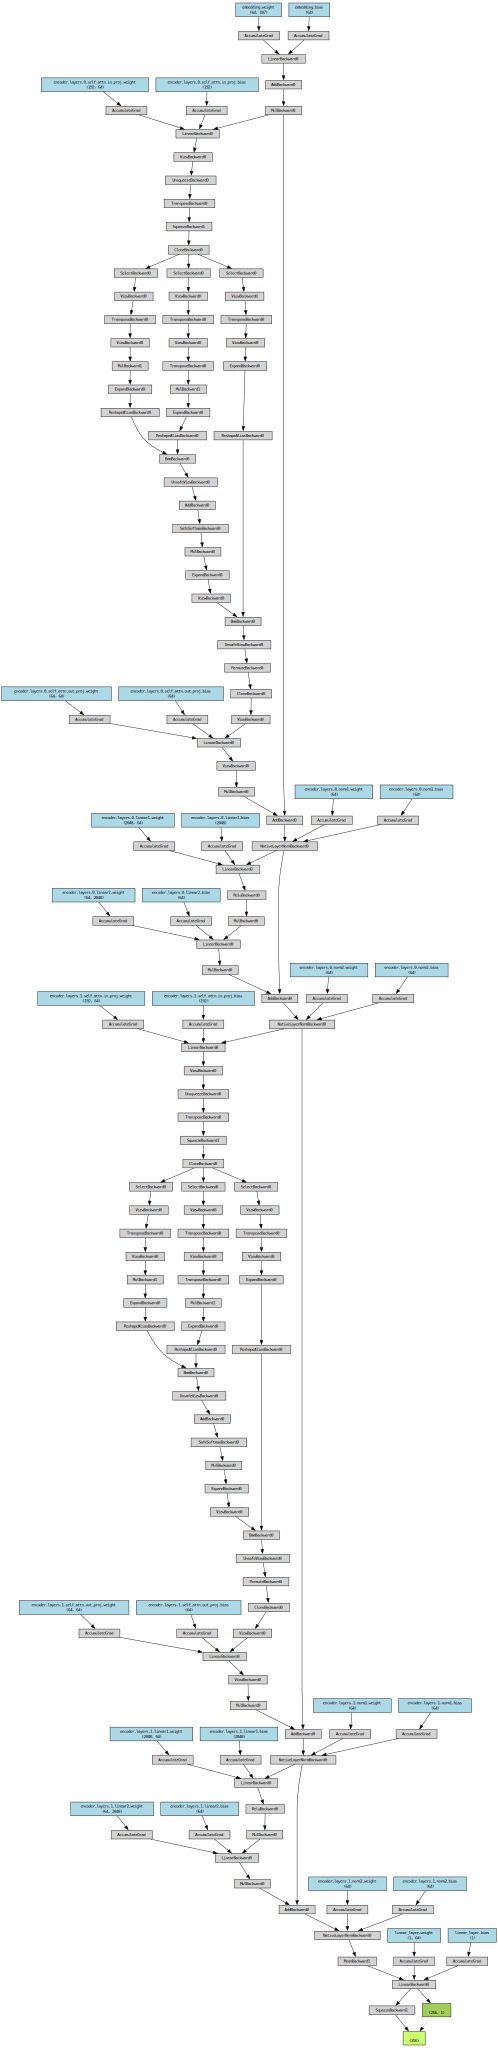

In [16]:
# make the graph
dot = make_dot(
    model(X, mask),
    params=dict(model.named_parameters()),
    show_attrs=False,
    show_saved=False
)
dot.render(
    filename="transformer_graph",  # base filename (no extension)
    format="pdf",                  # or "png", "pdf", etc.
    cleanup=True                   # remove the intermediate .gv file
)
# render inline (in Colab/Jupyter)
dot

In [26]:
import torch, torch.nn as nn, numpy as np

# 1) Build the “wrong” PE exactly as in your code:
class PEWrong(nn.Module):
    def __init__(self, d_model, max_len=20):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
        self.dropout = nn.Dropout(0.0)               # turn off randomness

    def forward(self, x):
        # x: (seq_len, batch, d_model)
        print(" input x.shape       =", x.shape)
        sl = x.size(1)   # BUG: grabbing batch_size instead of seq_len
        print(" slicing self.pe[:, :sl].shape =", self.pe[:, :sl].shape)
        out = x + self.pe[:, :sl]      # broadcast along dim=0
        return self.dropout(out)

# 2) Create a dummy input
d_model = 8
x = torch.zeros(5, 3, d_model)  # seq_len=5, batch=3

# 3) Run it in eval mode so dropout doesn’t mask out the equality we want to test
pe = PEWrong(d_model).eval()
out = pe(x)

# 4) Now check two different time‑steps
print(" out[0] == out[1] ? ", torch.allclose(out[0], out[1]))
# This should print True, because every time‑step got the *same* slice of pe.

# 5) And confirm what the correct slice shape should be
print(" correct slice shape =", pe.pe[:, :x.size(0), :].shape)

 input x.shape       = torch.Size([5, 3, 8])
 slicing self.pe[:, :sl].shape = torch.Size([1, 3, 8])
 out[0] == out[1] ?  True
 correct slice shape = torch.Size([1, 5, 8])


In [21]:
print(out.shape)

torch.Size([5, 3, 8])
